# Analysis of the Seattle Fire Department 911 calls
## Francisco Javier Salido Magos
Human Centered Data Science, DATA 512, Fall 2018.

M.S. Data Science,
University of Washington.

Final Project

This code is made available for re-use under a MIT license. (https://opensource.org/licenses/MIT)

#### Reproducing and replicating this study
The code below should run without any glitches and reproduce the results currently stored in this workbook.

Having said that, it is important to point out that the volume of the datasets employed in this study far exceeds Github recommendations for maximum file size (more than a GB for two of the datasets). Thus, the raw data uploaded to the Github page represents only a sample of that available (checked with Jonathan for this). Full datasets can be obtained from the sources described in this notebook, and the README for the project. This workbook manages to yield results on the contents of the full raw datasets because we have generated much smaller "clean" datasets encoded to minimize file size, that are stored in the appropriate directory in the Github repository.

- You should be able to reproduce this study by downloading the raw datasets from the source, making sure that the contents of those files matches the dates discussed for each dataset in the corresponding "Schematizing and cleansing" section of this workbook.
- For replication, please be aware that the City of Seattle stopped updating the rainfall measurement dataset on May 1st of 2017. Unless the City produces new data, replication of this study using the code below will yield updated results and visualizations for all but the rainfall visualizations, and the linear regression portion of the results.

Finally, if you are going to either reproduce or replicate this study, you will want to pay special attention to the block of code under the Markdown cell entitled "IMPORTANT: On Reproducing and Replicating this study" found later on in this notebook.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D

# Schematizing and cleansing of SFD 911 calls data
Raw data comes from the "Seattle Real Time Fire 911 Calls" dataset, available from the Open Data Program of the City of Seattle, which can be found here: https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj

This dataset is licensed under a CC0 1.0 Universal license: https://creativecommons.org/publicdomain/zero/1.0/legalcode

Each row in this dataset represents one call made to the SFD 911 number, and includes the type of call, date and time, latitude/longitude coordinates, address and incident number. Data covers the period from June 29th, 2010 until December 8th, 2018 (Note that we drop all data from 2010 in our first block of code below).

The block of code below loads the dataset and immediately drops the report location, address and incident number fields, which we will not use, as well as any rows that are missing either latitutde or longitude data. We then expand the Datetime field to extract Month, Day and Year of the call. We keep those and drop the data we will not need.

Note that the date information in the raw dataset has been uploaded using two different formats, one follows a Day-Year-Month format and the other follows the more traditional Month/Day/Year format, so we have to normalize this. Finally, we drop calls that occurred in 2010, cast Year, Month and Day data as integers, and re-index the dataset.

In [2]:
# Reading raw data 
calls = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/raw_data/SFD/Seattle_Fire_911.csv',header=0,encoding = 'unicode_escape', dtype = {'Type':object, 'Datetime':object, 'Latitude':pd.np.float64, 'Longitude':pd.np.float64}, skipinitialspace = True).fillna(0)

# Dropping columns 0 (Adress), 5 (Report Location) and 6 (Incident Number), and also rows that are missing lat or long.
calls = calls.iloc[:,1:5]
calls = calls[(calls.Latitude !=0) & (calls.Longitude !=0)]

# Breaking down the Datetime field into Month/Day/Year/Time format, and dropping Time and redundant fields
calls = pd.concat([calls,calls['Datetime'].str.split(' |T',expand=True)],axis=1)
calls.columns = ['Type','Datetime','Lat','Long','Date','Time','M','Sec']
calls = pd.concat([calls,calls['Date'].str.split('/|-',expand=True)],axis=1)
calls.columns = ['Type','Datetime','Lat','Long','Date','Time','M','Sec','Month','Day','Year']
calls = calls.drop(['Datetime','Time','M','Sec','Date'],axis=1)

# Correcting for the different date formats used in in some rows (Day/Year/Month vs Month/Day/Year)
df = calls.loc[calls.Month > '12']
calls = calls.loc[calls.Month < '13']
df = df[['Type','Lat','Long','Day','Year','Month']]
df.columns = ['Type','Lat','Long','Month','Day','Year']
calls = pd.concat([calls,df],axis=0)

# Dropping pre-2011 data and casting Month/Day/Year data as integers.
calls = calls[calls.Year !='2010']
calls.Year = pd.to_numeric(calls.Year,downcast='integer')
calls.Month = pd.to_numeric(calls.Month,downcast='integer')
calls.Day = pd.to_numeric(calls.Day,downcast='integer')
calls.reset_index(drop = True, inplace = True)

In our next block of code we generate a table listing all unique types of incidents that are found in the dataset. We used this to manually identify which calls are related to fire incidents and which are not. If you plan to reproduce this research you will likely be using a more up-to-date dataset, so we would suggest you review the table "../data_clean/SFD/Incident_types.csv" in case you need to update the keywords used in this block of code to differentiate between the two types of incidents.

Keywords that identify fires are listed in the second line of code below (ignore lines with comments): "Fire", "FIRE" and "RED". Note that there's a second set of keywords that identify incidents where there was a fire but are not likely to be related to air temperature or rainfall conditions: "Auto" (for "automatic"), "Derailment", "Transformer" and "Electrical".

The resulting list of incident types and their classification are stored in "../data_clean/SFD/Incident_types.csv"

In [3]:
# First we get a list of unique values in the Type field to analyze manually.
df = pd.Series(pd.unique(calls['Type']))

# After selecting key words for the two classes of incident (fire or no fire), we append this information to the table and store it.
df = pd.concat([df, (df.str.contains('Fire|FIRE|RED',regex=True) & -df.str.contains('Auto|Derailment|Transformer|Electrical',regex=True))],axis=1)
df.columns=['Type','Class']
df.to_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/SFD/Incident_types.csv',index=False)

This block of code classifies each row in the full "Calls" dataset into two classes, using the field "Class". The classes are "fire related" (True) and "non-fire related" (False). We then drop the incident "Type" field, as we will not use it any longer.

Calls are then classified into three city areas, using the field "Zone". The areas are north Seattle (all calls registered north of Union bay, Portage bay, Lake Union or the canal that goes from Lake Union to Puget Sound), central Seattle (territory lying south of the above boundaries and, roughly, north of latitude 47.59), and south Seattle.

The final, clean dataset, is stored in "../data_clean/SFD/Calls_Incident.csv"

In [4]:
# Having documented our taxonomy in in the previous block of code, we proceed to classify all incidents in the Calls dataframe
# as fire (True) or no-fire (False) in the Class field.
calls = pd.concat([calls,(calls['Type'].str.contains('Fire|FIRE|RED',regex=True) & -calls['Type'].str.contains('Auto|Derailment|Transformer|Electrical',regex=True))],axis=1)
calls.columns = ['Type','Lat','Long','Month','Day','Year','Class']

# Dropping the Type field
calls = calls.drop('Type',axis=1)

# Classifying each row in the Calls dataframe according to its location.
# We use the field Zone and classify into north (1), central (2) and south (3) Seattle.
calls = pd.concat([calls,pd.DataFrame(np.zeros(calls.shape[0],dtype=int) + 2,columns=['Zone'])],axis=1)
calls.loc[((calls.Lat > 47.6521) & (calls.Long > -122.3344)),'Zone'] = 1
calls.loc[((calls.Lat > 47.6662) & (calls.Long < -122.3892)),'Zone'] = 1
m = (47.6662 - 47.6407)/(122.3344 - 122.3892)
b = 47.6662 + m*122.3892
calls.loc[((calls.Long > -122.3892) & (calls.Long < -122.3344) & (calls.Long*m+b < calls.Lat)), 'Zone'] = 1
calls.loc[calls.Lat < 47.5899,'Zone'] = 3
calls.loc[((calls.Long < -122.3755) & (calls.Lat < 47.599)), 'Zone'] = 3

calls.head()

,Lat,Long,Month,Day,Year,Class,Zone
0,47.540683,-122.286131,11,9,2011,False,3
1,47.665034,-122.340207,11,9,2011,False,1
2,47.619575,-122.324257,11,9,2011,False,2
3,47.597406,-122.317228,11,9,2011,False,2
4,47.562472,-122.385455,11,9,2011,False,3


# Schematizing and cleansing Air Temperature readings.
Raw data for air temperature comes from the "Road Weather Information Stations" dataset available from the Open Data Program of the City of Seattle, and can be found here:https://data.seattle.gov/Transportation/Road-Weather-Information-Stations/egc4-d24i

This same webpage indicates that the dataset is Public Domain data, and thus can be used for this study.

Each row in this dataset represents one measurement taken at five minute intervals by one of ten stations spread around the city. The dataset is large (almost 3GB at the time of this writing), and likely to grow. Data covers the period from March 3rd, 2014 until April 16th, 2018.

There are some columns that we don't need, so we drop fields 3 (RecordId) and 4 (RoadSurfaceTemperature). The field DateTime is then broken down to extract the Month/Day/Year of each measurement, and then we get rid of redundand data and cast Month, Day and Year as integers. 

In [5]:
# Reading raw weather data and dropping fields RecordId and RoadSurfaceTemperature
weather = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/raw_data/Weather/Road_Weather_Information_Stations.csv',header=0,encoding = 'unicode_escape').fillna(0)
weather = weather[['StationName','StationLocation','DateTime','AirTemperature']]

# Separating DateTime field into Date, Time and label for am/pm.
weather = pd.concat([weather,weather['DateTime'].str.split(' ',expand=True)],axis=1)
weather.columns = ['StationName','StationLocation','DateTime','AirTemperature','Date','Time','xM']

# Further splitting field Date into Month, Day and Year. Dropping fields for DateTime and Date
weather = pd.concat([weather[['StationName','StationLocation','AirTemperature','Date']],weather['Date'].str.split('/',expand=True)],axis=1)
weather.columns = ['StationName','StationLocation','AirTemperature','Date','Month','Day','Year']
weather = weather.drop('Date',axis=1)

# Converting fields for Month, Day and Year, which are "objects," into integers.
weather.Year = pd.to_numeric(weather.Year,downcast='integer')
weather.Month = pd.to_numeric(weather.Month,downcast='integer')
weather.Day = pd.to_numeric(weather.Day,downcast='integer')

We use the next block fo code to extract individual latitude and longitude into two separate fields, from the field StationLocation. We then drop StationLocation and clean the new Lat and Long fields, and cast these as type 'float'.

In [6]:
# Splitting field StationLocation into fields Lat (latitude) and Long (longitude).
weather = pd.concat([weather,weather['StationLocation'].str.split(',',expand=True)],axis=1)
weather.columns = ['StationName','StationLocation','AirTemperature','Month','Day','Year','Lat','Long']

# Dropping the field StationLocation, and getting rid of the open parenthesis "(" symbol before Lat and the ")" after Long.
weather = weather.drop('StationLocation',axis=1)
weather['Lat'].replace(regex=True,inplace=True,to_replace = r'\(',value=r'')
weather['Long'].replace(regex=True,inplace=True,to_replace = r'\)',value=r'')

# Converting latitude and longitud strings into floating point numbers.
weather.Lat = pd.to_numeric(weather.Lat,downcast='float')
weather.Long = pd.to_numeric(weather.Long,downcast='float')

To reduce the size of our "clean" dataset, we replace the names of the measuring stations, which are stored as character strings ("objects" in Python) in the original dataset, with integer station numbers. This should also improve the performance of our code later on.

In [7]:
# Extracting list of unique Station Names
lista = weather['StationName'].unique()

# Replacing Station Names with an integer number for each station.
for j in range(0,len(lista)):
    weather.loc[weather.StationName == lista[j], 'StationName'] = j
    
# Converting the new StationName from "object" (character string) into integer.
weather.StationName = pd.to_numeric(weather.StationName,downcast='integer')

# Print the list of weather station names.
lista

array(['35thAveSW_SWMyrtleSt', 'AlaskanWayViaduct_KingSt',
       'AlbroPlaceAirportWay', 'AuroraBridge',
       'HarborAveUpperNorthBridge', 'MagnoliaBridge', 'NE45StViaduct',
       'RooseveltWay_NE80thSt', 'SpokaneSwingBridge',
       'JoseRizalBridgeNorth'], dtype=object)

Analysis of the temperature data reveals that there are some inaccuracies in it, which show up in the form of air temperatures that are either too high or too low. We remove the rows in the dataset that correspond to these outliers.

According to the Seattle Weather blog, the highest temperature recorded in Seattle was 103 degrees Farenheit, on July 2009. On that same day, Boeing field and the National Weather Service in North Seattle recorded 105 degrees. http://www.seattleweatherblog.com/weather-records/july-29ths-scorching-past/

The same blog indicates that the lowest temperature recorded in Seattle was measured at Seatac airport, at 0 degrees Farenheit, on January 1950. http://www.seattleweatherblog.com/temperature-stats/

So, to allow for varying measurements in different stations, we settled for 110 degrees Farenheit as the maximum allowable temperature, and -5 degrees Farenheit as the minimum.

In [8]:
# Getting rid of outliers as they are unlikely to have happened.
df = weather.loc[weather.AirTemperature > 110]
weather = weather.loc[weather.AirTemperature <= 110]
print('Stations affected by measurements over the limit of 110 degrees Farenheit are:\n',lista[df['StationName'].unique()])

# Getting rid of negative outliers as they are unlikely to have happened.
df = weather.loc[weather.AirTemperature < -5]
weather = weather.loc[weather.AirTemperature >= -5]
print('\nStations affected by measurements under the limit of -5 degrees Farenheit are:\n',lista[df['StationName'].unique()])
weather.reset_index(drop = True, inplace = True)

Stations affected by measurements over the limit of 110 degrees Farenheit are:
 ['RooseveltWay_NE80thSt' '35thAveSW_SWMyrtleSt' 'AlaskanWayViaduct_KingSt']

Stations affected by measurements under the limit of -5 degrees Farenheit are:
 ['AlbroPlaceAirportWay' 'AlaskanWayViaduct_KingSt']


In the block of code below we correct the latitude figure for a few rows that are incorrect, assign each weather station to the corresponding city zone (North, Central, South), and reflect this in the Zone field. Finally, we compute average daily and average monthly temperatures in each station, and store the results in a monthly and daily datasets.

In [9]:
# Assigning the correct city Zone for each station.
weather.loc[weather.Lat == 47.40503,'Lat'] = 47.571693
weather = pd.concat([weather,pd.DataFrame(np.zeros(weather.shape[0],dtype=int) + 2,columns=['Zone'])],axis=1)
weather.loc[((weather.StationName == 6) | (weather.StationName == 7)),'Zone'] = 1
weather.loc[((weather.StationName == 0) | (weather.StationName == 2) | (weather.StationName == 4) | (weather.StationName == 8)), 'Zone'] = 3

# Compute the average daily temperature for each station.
weather_day = weather.groupby(['Zone','StationName','Year','Month','Day']).mean()
weather_day = weather_day.sort_values(['Zone','StationName','Year','Month','Day'], ascending=True)
weather_day.reset_index(inplace = True)

# Compute the average monthly temperature for each station.
weather = pd.DataFrame(weather.groupby(['Zone','StationName','Year','Month'])['AirTemperature'].mean())
weather = weather.sort_values(['Zone','StationName','Year','Month'], ascending=True)
weather.reset_index(inplace = True)

weather_day.head()

,Zone,StationName,Year,Month,Day,AirTemperature,Lat,Long
0,1,6,2014,3,3,52.713000,47.66127,-122.301926
1,1,6,2014,3,4,43.121000,47.66127,-122.301926
2,1,6,2014,3,12,47.355667,47.66127,-122.301926
3,1,6,2014,3,13,54.161310,47.66127,-122.301926
4,1,6,2014,3,14,52.546868,47.66127,-122.301926


# Schematizing and cleansing Rainfall readings.
Raw data for air temperature comes from the "Observed Rain Gauge Readings - Oct 2002 to May 2017" dataset available from the Open Data Program of the City of Seattle, and can be found here:https://data.seattle.gov/City-Business/Observed-Rain-Gauge-Readings-5-Min-Intervals-Oct-2/cg4m-emwz

This same webpage indicates that the dataset is Public Domain data, and thus can be used for this study.

Each row in this dataset represents one measurement, taken at five minute intervals, by one of thirteen stations that are spread around the city. The dataset is also large, at more than 1.5 GB, and covers the period from October 2003 until May 1st, 2017 (Note that we drop all data prior to March 3rd, 2014 in the second block of code below).

There's some redundancy in the data, and fields that we don't need, so we drop fiels 0 to 2, and 6 (record_number, month, quality_code and wateryear) and, since we don't have air temperature data prior to 2014, we also drop all rainfall measurements taken before that year.

In [10]:
# Read rainfall dataset.
rain = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/raw_data/Rain/Observed_Rain_Gauge_Readings_-_5_Min_Intervals_-_Oct_2002_to_May_2017.csv',header=0,encoding = 'unicode_escape').fillna(0)

# Drop data prior to 2014, and columns 0 (record_number), 1 (month), 2 (quality_code) and 6 (wateryear) 
rain = rain[rain['wateryear'] > 2013]
rain = rain[['rainfall_in','site','time']]
rain.reset_index(inplace = True)
rain = rain.drop(['index'],axis=1)

In the block of code below we extract the Month, Day and Year of each measurement and drop redundant data. These three fields are then cast as integers, and we sort all entries in ascending order by date.

In [11]:
# Split the time field into Month, Day and Year and drop redundant fields
rain = pd.concat([rain,rain['time'].str.split(' ',expand=True)],axis=1)
rain.columns = ['Rainfall','Site','time','Date','Time2','M']
rain = pd.concat([rain,rain['Date'].str.split('/',expand=True)],axis=1)
rain.columns = ['Rainfall','Site','time','Date','Time2','M','Month','Day','Year']
rain = rain.drop(['time','Date','Time2','M'],axis=1)

# Casting Year, Month and Day columns as integers.
rain.Year = pd.to_numeric(rain.Year,downcast='integer')
rain.Month = pd.to_numeric(rain.Month,downcast='integer')
rain.Day = pd.to_numeric(rain.Day,downcast='integer')

# Sort all rows by date.
rain = rain[rain['Year'] + (rain['Month']/100) + (rain['Day']/10000) > 2014.0302]
rain = pd.DataFrame(rain.groupby(['Site','Year','Month','Day']).sum())
rain = rain.sort_values(['Year','Month','Day'], ascending=True)
rain.reset_index(inplace = True)

Finally, asign sites (aka measuring stations) to city Zones, cast Zones as integer, compute the average daily rainfall measures for each Zone, and sort measurements by date.

In [12]:
# Assign measuring stations, sites, to city Zones (north, central and south)
rain.loc[((rain.Site == 'RG01') | (rain.Site == 'RG02') | (rain.Site == 'RG03') | (rain.Site == 'RG04') | (rain.Site == 'RG07') | (rain.Site == 'RG08') | (rain.Site == 'RG09')),'Site'] = 1
rain.loc[((rain.Site == 'RG11') | (rain.Site == 'RG12') | (rain.Site == 'RG20_25')),'Site'] = 2
rain.loc[((rain.Site == 'RG05') | (rain.Site == 'RG10_30') | (rain.Site == 'RG14') | (rain.Site == 'RG15') | (rain.Site == 'RG16') | (rain.Site == 'RG17') | (rain.Site == 'RG18')),'Site'] = 3
rain.columns = ['Zone','Year','Month','Day','Rainfall']

# Cast the Zone column as integer.
rain.Zone = pd.to_numeric(rain.Zone,downcast='integer')

# Compute daily average rainfall for each city zone.
rain = pd.DataFrame(rain.groupby(['Zone','Year','Month','Day']).mean())
rain = rain.sort_values(['Year','Month','Day'], ascending=True)
rain.reset_index(inplace = True)
rain.head()

,Zone,Year,Month,Day,Rainfall
0,1,2014,3,3,0.992857
1,2,2014,3,3,0.910000
2,3,2014,3,3,0.744286
3,1,2014,3,4,0.180000
4,2,2014,3,4,0.196667


### IMPORTANT: On Reproducing and Replicating this study
The block of code below executes two functions:

- It stores the datasets resulting from the schematization and cleansing of the three raw datasets. 
- It then reads the cleansed datasets to memory so that we can then proceed to our analysis. 

Note that the names of the stored files are different from those being read. This was done deliberately because of the raw data file sizes issues discussed at the top of this workbook.

If you are looking at either replicating or reproducing this study using datasets you have downloaded from the source, you will want to remove the "_subset" portion of the csv file names in the first three lines of code below.

If you simply want to run the code and verify that it works, do not modify any line of code.

In [13]:
calls.to_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/SFD/Calls_Incident_subset.csv',index=False)
weather_day.to_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/Weather/Daily_Temp_MeasuresZone_subset.csv',index=False)
rain.to_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/Rain/RainDay_subset.csv',index=False)

temperatureDay = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/Weather/Daily_Temp_MeasuresZone.csv',header=0,encoding = 'unicode_escape')
calls = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/SFD/Calls_Incident.csv',header=0,encoding = 'unicode_escape')
rainDay = pd.read_csv('c:/Users/Castor18/Documents/Data-512-final/data_clean/Rain/RainDay.csv',header=0,encoding = 'unicode_escape')

# Research question 1: How has the yearly volume of 911 calls for both; emergency medical services and fire response, changed over this seven year period?

# Research question 2: Are these changes statistically significant and if so, what are the trends for both types of calls?
These are the first research questions we put forth in our proposal. While the detailed results are discussed below, a summary of our conclusions for these two questions is:

- There is significant statistical evidence that supports an increase in yearly volume call for non-fire related calls.
- There is no significant statistical evidence that supports an increase in yearly call volume for fire-related 911 calls.

#### Code:
The block of code below begins by separating all SFD 911 calls into those that are fire-related and those that are not. We then plot the two bar charts shown below.
#### Analysis:
The barcharts seem to show a modest but steady yearly increase in the volume of calls of both types, until 2016 for non-fire related calls, and until 2015 for fire-related calls. After that period however, volume seems to drop slightly in 2017, with a possible recovery in 2018 (keep in mind data for December 2018 goes up only until the 8th of the month). Evidence of growth, so far, is not conclusive.the research questions we put forth in our proposal.

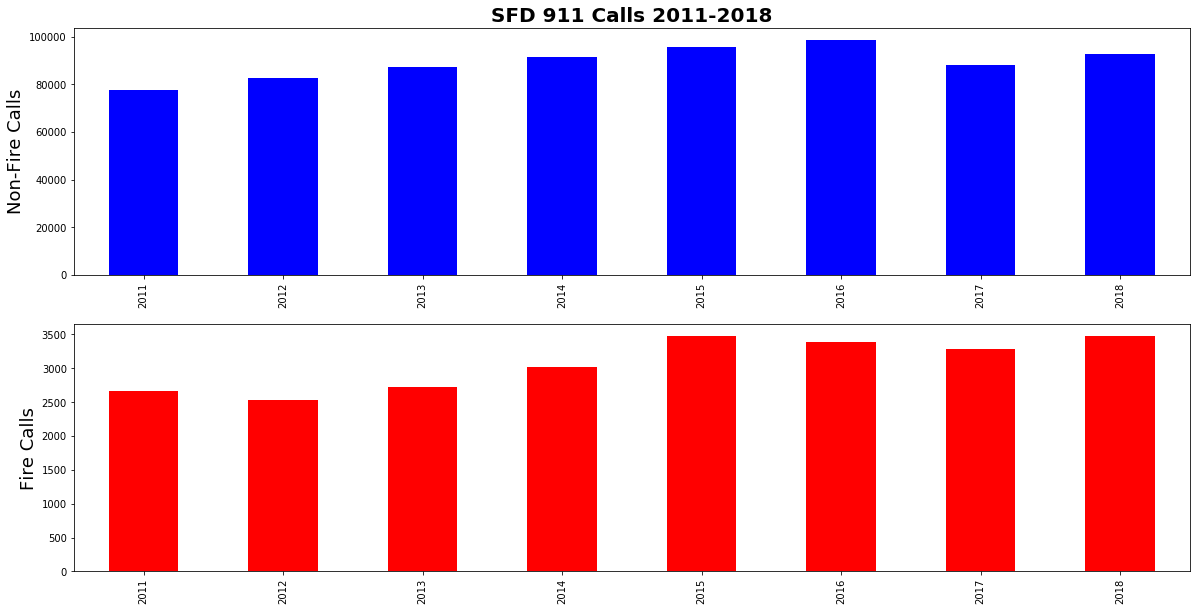

In [14]:
# Splitting the 911 calls dataset into fire-related and non-fire related calls.
callsFire = calls[calls.Class == True]
callsOther = calls[calls.Class == False]

# Plotting bar chart for non-fire related 911 calls.
plt.rcParams['figure.figsize'] = [20.0, 10.0]
x = ('2011','2012','2013','2014','2015','2016','2017','2018')
ax = plt.subplot(211)
calls_O = callsOther['Year'].value_counts(sort=True,ascending = True)
calls_O = calls_O.sort_index()
ax.set_title('SFD 911 Calls 2011-2018',fontsize=20,fontweight='bold')
plt.ylabel('Non-Fire Calls',fontsize=18)
plt.tick_params(axis=x,which='both',bottom=False,top=False,labelbottom=False)
calls_O.plot(kind='bar',color='b')

# Plotting bar chart for fire-related 911 calls.
ax = plt.subplot(212)
calls_F = callsFire['Year'].value_counts(sort=True,ascending = True)
calls_F = calls_F.sort_index()
plt.ylabel('Fire Calls',fontsize=18)
plt.tick_params(axis=x,which='both',bottom=False,top=False,labelbottom=False)
calls_F.plot(kind='bar',color='r')

#### Code:
The next block of code simply plots the two bar charts that show monthly volume for both types of calls.

#### Analysis:
There are a few interesting facts about these bar charts:

- There is a significant drop in volume for January and February of 2017, which could account for the apparent slow down in growth we observed in the yearly charts. Upon inspection, we found that there are no entries in the dataset starting January 12th through February 23rd. No explanation is given in the City of Seattle webpage so we assume data was lost.
- These monthly bar charts seem to show some growth in volume, which is more clearly perceptible in the non-fire related calls.
- We can observe a seasonal pattern in the volume of calls, much more clear in the case of fire-related calls. Volume seems to peak around the July-August timeframe, and trough in the January-February timeframe.

Still, no conclusive evidence of continued increase in volume.

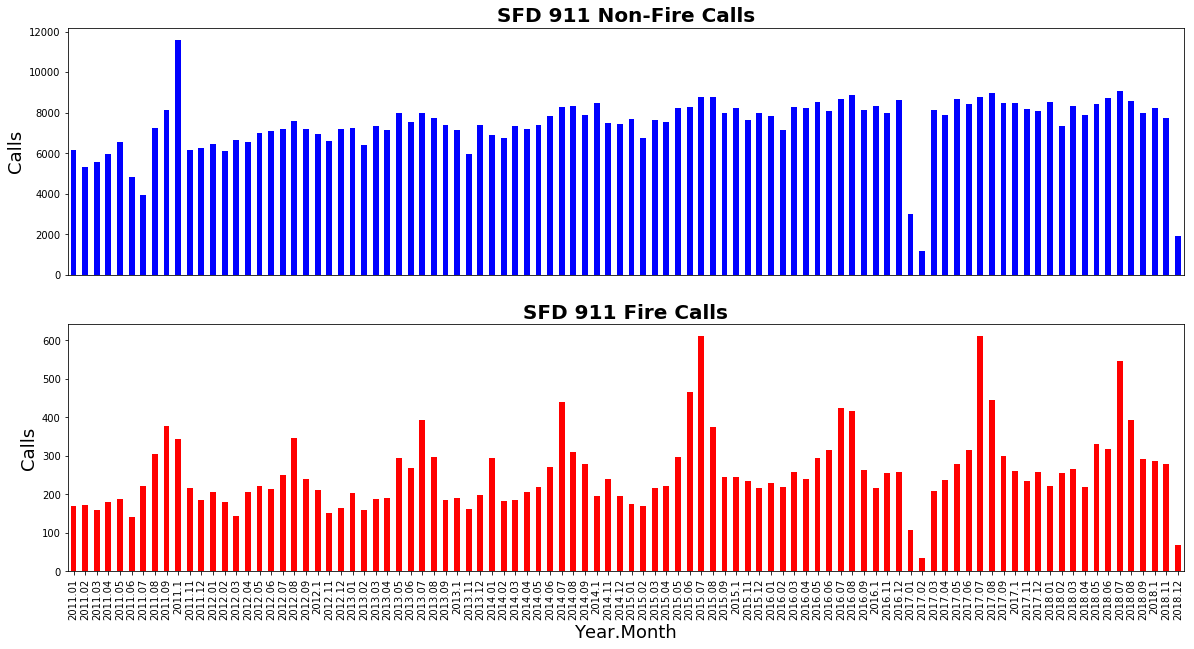

In [15]:
# Plotting monthly call volume for non-fire related 911 calls.
plt.rcParams['figure.figsize'] = [20.0, 10.0]
DateO = callsOther.Year + callsOther.Month/100
ax = plt.subplot(211)
hist = DateO.value_counts(sort=True,ascending = True)
hist = hist.sort_index()
ax.set_title('SFD 911 Non-Fire Calls',fontsize=20,fontweight='bold')
plt.ylabel('Calls',fontsize=18)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
hist.plot(kind='bar',color='b')

# Plotting monthly call volume for fire-related calls.
DateF = callsFire.Year + callsFire.Month/100
ax = plt.subplot(212)
hist = DateF.value_counts(sort=True,ascending = True)
hist = hist.sort_index()
ax.set_title('SFD 911 Fire Calls',fontsize=20,fontweight='bold')
plt.ylabel('Calls',fontsize=18)
plt.xlabel('Year.Month',fontsize=18)
hist.plot(kind='bar',color='r')


#### Code:
In this block of text we first aggregate call volumes by day for both, fire-related and non-fire related calls, and then compute monthly mean volume of calls for each month/year in the dataset. We then use the monthly means for each year as a separate series and compute a hypothesis test to establish whether the yearly variations can be attributed to an actual increase in the trend.

#### Analysis:

- For non-fire related calls, our hypothesis test rejected the null hypothesis that the mean volume of monthly calls had remained constant during the period we analyze. Thus, there is evidence indicating that the monthly volume of non-fire related calls increased during this period.
- For fire-related calls, our hypothesis test failed to reject the null hypothesis that the mean volume of monthly calls had remained constant during the period we analyze. Thus, there is evidence indicating that the monthly volume of fire-related calls did not increase during this period.

From these results we conclude that the answer to our research question 1 is that there is statistical evidence that the volume of non-fire related calls is increasing over time, but we cannot make the same statement about fire-related calls which seem to have remained more or less constant.

In [16]:
callsRegO = pd.DataFrame(callsOther.groupby(['Year','Month','Day']).size())
callsRegO = callsRegO.sort_values(['Year','Month','Day'], ascending=True)
callsRegO.reset_index(inplace = True)
callsRegO.columns = ['Year','Month','Day','Calls']

callsRegF = pd.DataFrame(callsFire.groupby(['Year','Month','Day']).size())
callsRegF = callsRegF.sort_values(['Year','Month','Day'], ascending=True)
callsRegF.reset_index(inplace = True)
callsRegF.columns = ['Year','Month','Day','Calls']

df = pd.DataFrame(callsRegO.groupby(['Year','Month'])['Calls'].mean())
df.reset_index(inplace = True)
stat,p = f_oneway(df.Calls[df.Year == 2011],df.Calls[df.Year == 2012],df.Calls[df.Year == 2013],df.Calls[df.Year == 2014],df.Calls[df.Year == 2015],df.Calls[df.Year == 2016],df.Calls[df.Year == 2017],df.Calls[df.Year == 2018])
print('H0: Average monthly non-fire related calls are the same for all years 2011 through 2018')
print('F-statistic:',stat)
print('p-value:',p)
print('Given the p-value we obtain, we reject the null hypothesis H0 at a significance level of 95%')
print('This seems to indicate that the average monthly non-fire related calls have increased in volume through this period.\n')

df = pd.DataFrame(callsRegF.groupby(['Year','Month'])['Calls'].mean())
df.reset_index(inplace = True)
stat,p = f_oneway(df.Calls[df.Year == 2011],df.Calls[df.Year == 2012],df.Calls[df.Year == 2013],df.Calls[df.Year == 2014],df.Calls[df.Year == 2015],df.Calls[df.Year == 2016],df.Calls[df.Year == 2017],df.Calls[df.Year == 2018])
print('\nH0: Average monthly fire-related calls are the same for all years 2011 through 2018')
print('F-statistic:',stat)
print('p-value:',p)
print('Given the p-value we obtain, we fail to reject the null hypothesis H0 at a significance level of 95%')
print('This seems to indicate that the average fire-related monthly calls have remained constant through this period.')

H0: Average monthly non-fire related calls are the same for all years 2011 through 2018
F-statistic: 6.1843736163070515
p-value: 6.746603080643495e-06
Given the p-value we obtain, we reject the null hypothesis H0 at a significance level of 95%
This seems to indicate that the average monthly non-fire related calls have increased in volume through this period.


H0: Average monthly fire-related calls are the same for all years 2011 through 2018
F-statistic: 1.8445173262745287
p-value: 0.08863308842040664
Given the p-value we obtain, we fail to reject the null hypothesis H0 at a significance level of 95%
This seems to indicate that the average fire-related monthly calls have remained constant through this period.


## Are there differences in call distribution throughout the Seattle area?

#### Code:
Below we plot non-fire related calls and fire-related calls on separate graphs, where each 911 call is placed as a separate dot using its lat/long coordinates.

#### Analysis:
These visualizations are not part of our proposed research questions as we have no previous experience with the necessary tools. We found the results compelling, albeit incomplete. The plots below show that both types of calls are pretty much coming from all over Seattle, and that the SFD does provide assistance to neighboring communities to the north, south and across lake Washington, particularly when we look at non-fire related calls.

Lacking knowledge of the proper tools at this point in time, we have to leave an analysis of call density for the different areas/neighborhoods of the city for future work.

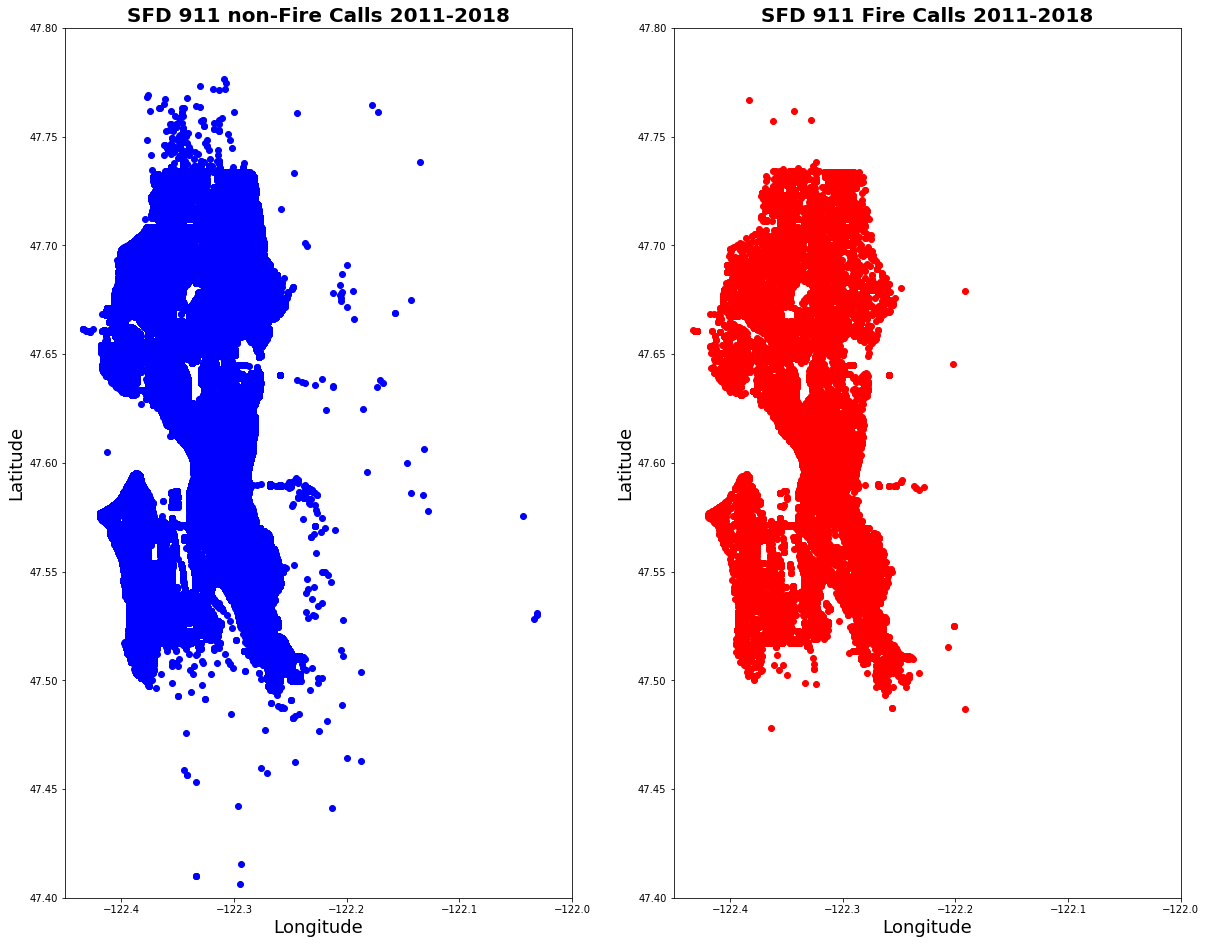

In [17]:
plt.rcParams['figure.figsize'] = [20.0, 16.0]

# Plotting each non-fire related call by its latitude/longitude coordinates.
ax=plt.subplot(121)
ax.set_title('SFD 911 non-Fire Calls 2011-2018',fontsize=20,fontweight='bold')
plt.xlim(-122.45,-122)
plt.ylim(47.4,47.8)
plt.scatter(callsOther.Long,callsOther.Lat,color='b')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)

# Plotting each fire-related call by its latitude/longitude coordinates.
ax=plt.subplot(122)
ax.set_title('SFD 911 Fire Calls 2011-2018',fontsize=20,fontweight='bold')
plt.xlim(-122.45,-122)
plt.ylim(47.4,47.8)
plt.scatter(callsFire.Long,callsFire.Lat,color='r')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)

plt.show()

#### Code:
A scatter plot showing each call as a dot located by its lat/long coordinates. Plot shows all calls; fire and non-fire related.

#### Analysis:

This visualization presents all calls, fire and non-fire related. We included it here for two reasons:

- To illustrate how we divided the city in zones to try and establish if there were changes in call volumes from one zone to another.
- To better illustrate the fact that there are notable patches in the density of calls in specific points. Comparing this to a map of the City of Seattle we confirmed that these empty patches, for the most part, are city parks or large expanses of terrain lacking buildings, such as railroad yards and load/unload shipping facilites.

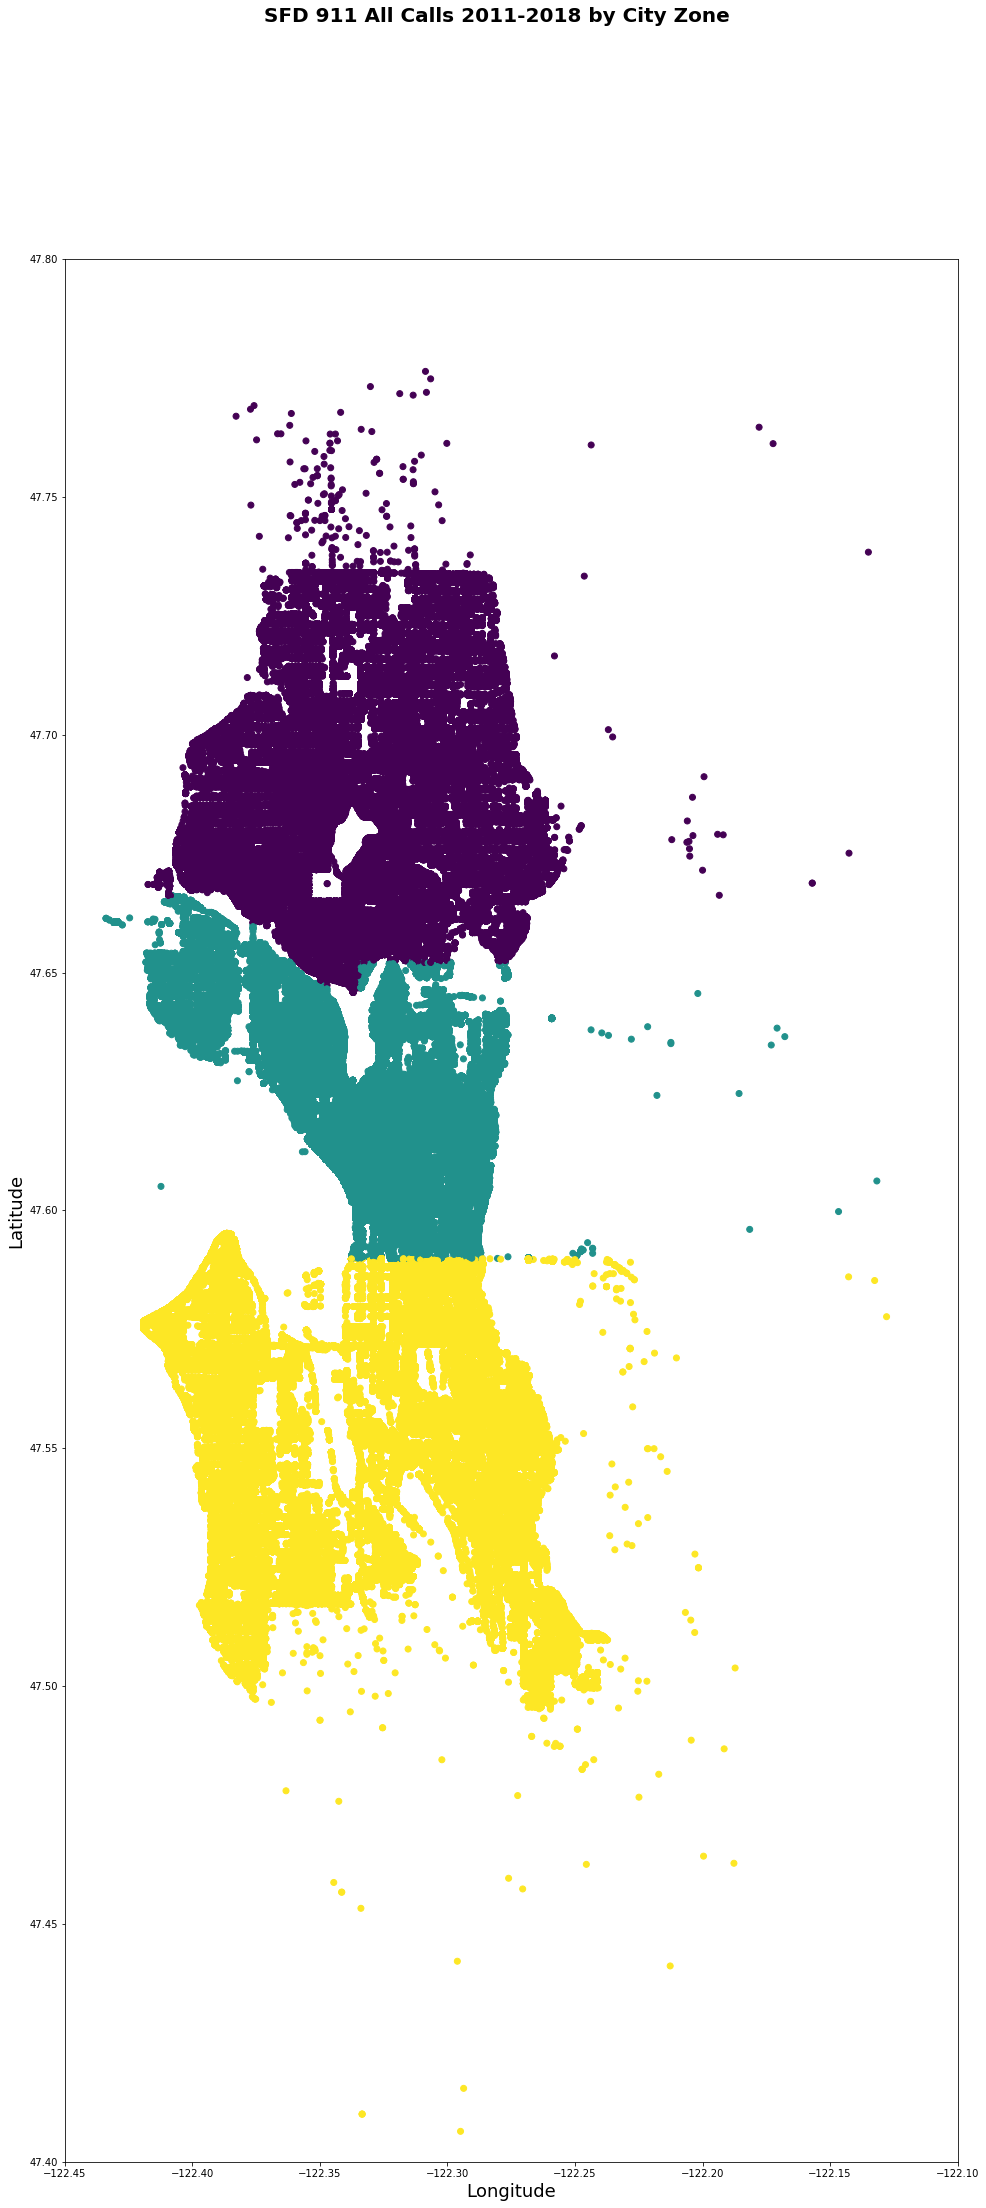

In [18]:
# Plot all calls by lat/long coordinates, and color code by city zone.
plt.rcParams['figure.figsize'] = [16.0, 35.0]
fig = plt.figure()
fig.suptitle('SFD 911 All Calls 2011-2018 by City Zone',fontsize=20,fontweight='bold')
plt.xlim(-122.45,-122.1)
plt.ylim(47.4,47.8)
plt.scatter(calls.Long,calls.Lat,c=calls.Zone)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.show()

#### Code:
This block of code generates two pie charts showing non-fire and fire related call distribution among the three city zones established in the previous visualization.

#### Analysis:
As a final point of interest to our limited analysis of call distribution throughout the city, we broke call volume down by zone and found that it is relatively evenly distributed for fire-related calls, with each area approaching one third of calls, and with the central Seattle zone showing higher demand for non-fire related calls, almost a half of total.

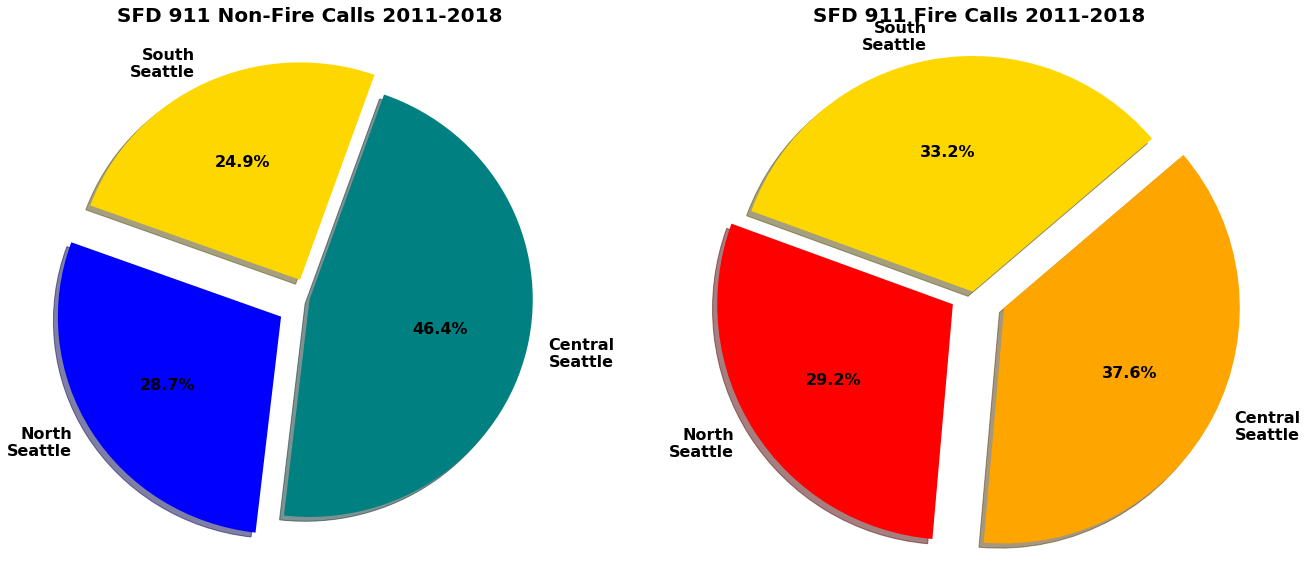

In [19]:
# Generating pie chart for non-fire related call distribution in the different zones.
plt.rcParams['figure.figsize'] = [22.0, 10.0]
labels='North\nSeattle','Central\nSeattle','South\nSeattle'
ax = plt.subplot(121)
ax.set_title('SFD 911 Non-Fire Calls 2011-2018',fontsize=20,fontweight='bold')
ax.pie([calls[calls.Zone == 1].shape[0],calls[calls.Zone == 2].shape[0],calls[calls.Zone == 3].shape[0]],explode=(0.15,0,0.1),labels=labels,colors=['blue','teal','gold'],autopct='%1.1f%%',startangle=160,shadow=True,textprops={'color':'black','fontsize':16,'fontweight':'bold'})

# Generating pie chart for fire-related call distribution in the different zones.
ax = plt.subplot(122)
ax.set_title('SFD 911 Fire Calls 2011-2018',fontsize=20,fontweight='bold')
ax.pie([callsFire[callsFire.Zone == 1].shape[0],callsFire[callsFire.Zone == 2].shape[0],callsFire[callsFire.Zone == 3].shape[0]],explode=(0.1,0.15,0),labels=labels,colors=['red','orange','gold'],autopct='%1.1f%%',startangle=160,shadow=True,textprops={'color':'black','fontsize':16,'fontweight':'bold'})
ax.axis('equal')
plt.show()

# Research question 3: Are call volumes correlated to local air temperature and rainfall? If so, what are the trends?
This is the most complex question in the proposal, and in order to better understand the trends, we again analyze fire-related and non-fire related calls separately. Again, we discuss detailed results below, but present a summary of our conclusions about the answer to this question here:

- There is a positive interaction between fire-related 911 SFD calls and average daily air temperature, albeit with a lower correlation than the boxplots seem to indicate.
- There is a negative interaction between fire-related 911 SFD calls and average daily rainfall, but the correlation is much lower than the boxplots seem to indicate.
- There is practically no correlation between non-fire related 911 SFD calls and either average daily air temperature or rainfall.
- Fitting multiple linear regression models shows that average daily air temperature and rainfall, combined or independently, do not provide enough of an explanation for fire-related 911 SFD call volumes. The best model is able to explain less than 18% of the variability in call volumes, so clearly other variables are at work here.
- Fitting multiple linear regression models shows that average daily air temperature and rainfall, combined or independently, do not provide help in explaining non-fire 911 SFD call volumes. The best model is able to explain less than 1% of the variability in call volumes.

#### Code:
For each of the following four blocks of code we take one variable and do a box-plot of its monthly behaviour over the period covered in the corresponding dataset.

#### Analysis: 
The first box-plot represents fire-related calls. The plot shows the same seasonality trend we saw earlier in the bar chart by month/year, albeit with a much more dramatic and clear illustration of how volume peaks in July, and less so in August. The variability in volume call during July is also much greater that it is for any other month. Yet, 75% of all July volumes are still higher than volumes for any other month except August, and a couple of outliers in June and September.

Text(0,0.5,'Calls')

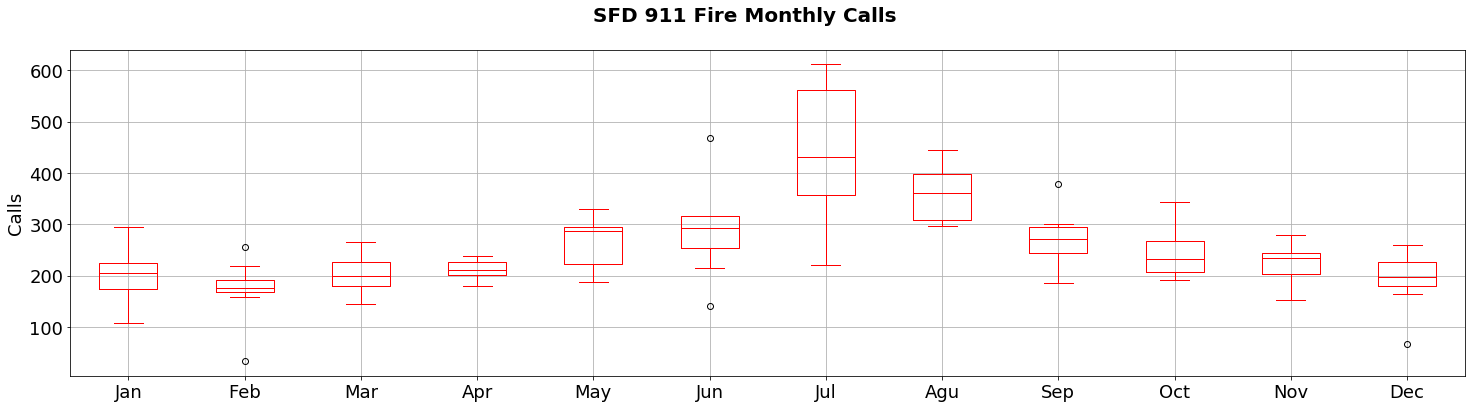

In [20]:
# Generating boxplot with fire-related 911 calls.
plt.rcParams['figure.figsize'] = [25,6]
calls_3DhistF = pd.crosstab(index=callsFire.iloc[:,4],columns=callsFire.iloc[:,2],values=1,aggfunc='sum')
calls_3DhistF.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
calls_3DhistF.plot.box(grid=True,color='r',fontsize=18)
plt.suptitle('SFD 911 Fire Monthly Calls',fontsize=20,fontweight='bold')
plt.ylabel('Calls',fontsize=18)

#### Analysis:
Next is the boxplot showing air-temperature trends. Here the seasonality is clear, with relatively narrow average temperature ranges in each month, and a clear trend of increase from January until July, and a clear decreasing trend from August to December. Notably, temperature peaks in July and August, clearly matching the trend in fire related calls shown in the previous plot.

Text(0,0.5,'Temperature [Farenheit]')

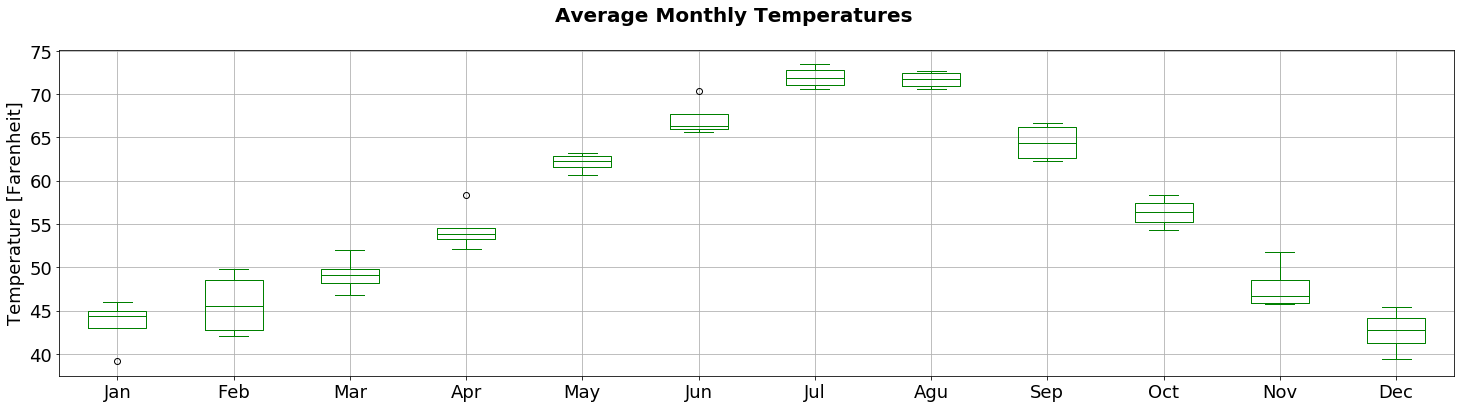

In [21]:
# Generating boxplot for average monthly air temperatures.
temp_3DhistT = pd.crosstab(index=temperatureDay.iloc[:,2],columns=temperatureDay.iloc[:,3],values=temperatureDay.iloc[:,5],aggfunc='mean')
temp_3DhistT.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
temp_3DhistT.plot.box(grid=True,color='green',fontsize=18)
plt.suptitle('Average Monthly Temperatures',fontsize=20,fontweight='bold')
plt.ylabel('Temperature [Farenheit]',fontsize=18)

#### Analysis: 
Average monthly rainfall shows an inverse trend when compared to both fire-related calls and air temperature monthly averages, peaking in the October to December period, and bottoming out in the June-July timeframe.

Text(0,0.5,'Rainfall [inches]')

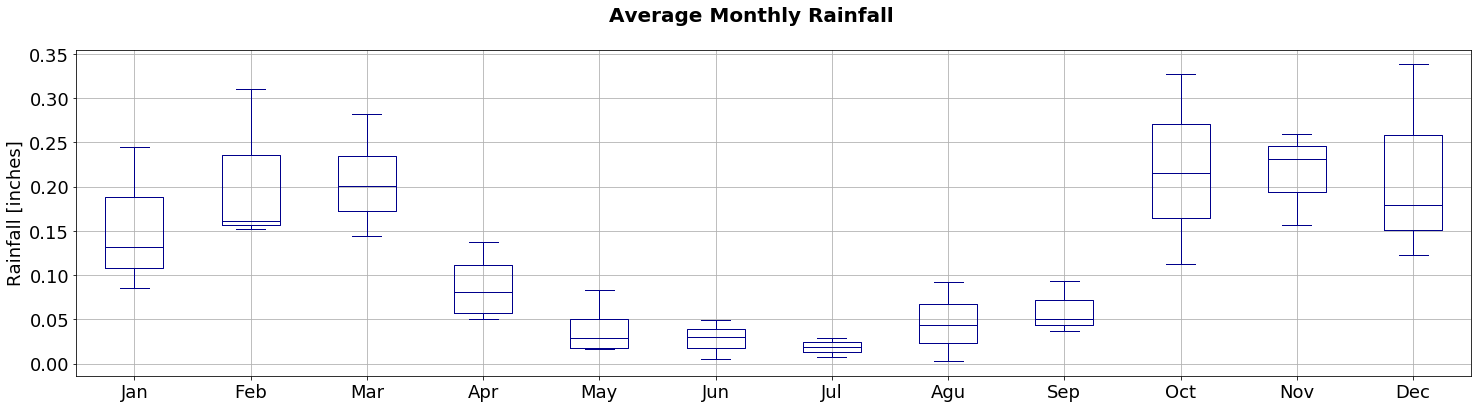

In [22]:
# Generating boxplot for average monthly rainfall.
rain_3Dhist = pd.crosstab(index=rainDay.iloc[:,1],columns=rainDay.iloc[:,2],values=rainDay.iloc[:,4],aggfunc='mean')
rain_3Dhist.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
rain_3Dhist.plot.box(grid=True,color='darkblue',fontsize=18)
plt.suptitle('Average Monthly Rainfall',fontsize=20,fontweight='bold')
plt.ylabel('Rainfall [inches]',fontsize=18)

#### Analysis:
Non-fire related calls on the other hand, don't seem to show any significant seasonal variation. We can see a drop in February, but that could well be the result of the call data that is missing for February 2017, which is 22 out of the 28 days in the month. No visible indications of any correlation to either air temperature or rainfall measurements.

Text(0,0.5,'Calls')

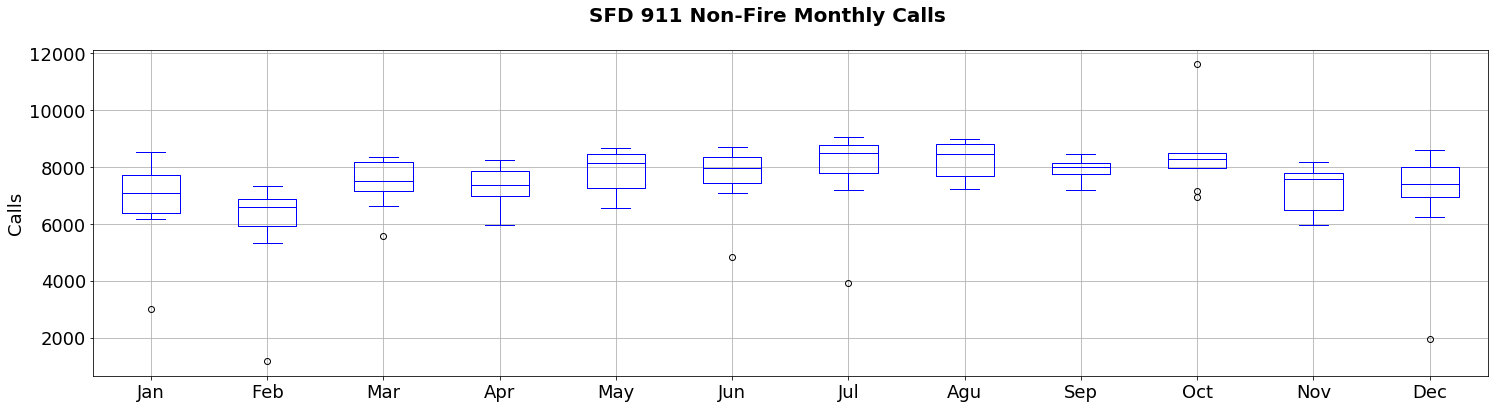

In [23]:
# Generating boxplot for average monthly non-fire related 911 calls.
calls_3DhistF = pd.crosstab(index=callsOther.iloc[:,4],columns=callsOther.iloc[:,2],values=1,aggfunc='sum')
calls_3DhistF.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Agu','Sep','Oct','Nov','Dec']
calls_3DhistF.plot.box(grid=True,color='b',fontsize=18)
plt.suptitle('SFD 911 Non-Fire Monthly Calls',fontsize=20,fontweight='bold')
plt.ylabel('Calls',fontsize=18)

Since each of the three datasets we employ in this project (911 calls and air temperature and rainfall measurements) covers a different time period, and since for our linear regression analysis we need time periods to match, the following three blocks of code drop all data that does not match the overlapping period for the three datasets.

The overlapping period covers March 3rd, 2014 to May 1st, 2017.

#### Code:
The block of code below drops all call data not in the overlapping period

In [24]:
# Dropping all rows containing call data prior to March 3rd, 2014.
callsRegF = callsRegF[callsRegF['Year'] + (callsRegF['Month']/100) + (callsRegF['Day']/10000) > 2014.0302]
callsRegO = callsRegO[callsRegF['Year'] + (callsRegO['Month']/100) + (callsRegO['Day']/10000) > 2014.0302]

# Dropping all rows containing call data after May 1st, 2017.
callsRegF = callsRegF[callsRegF['Year'] + (callsRegF['Month']/100) + (callsRegF['Day']/10000) < 2017.0502]
callsRegO = callsRegO[callsRegO['Year'] + (callsRegO['Month']/100) + (callsRegO['Day']/10000) < 2017.0502]

#### Code:
The block of code below computes mean daily air temperatures in Seattle, and drops all air temperature data after May 1st, 2017.

In [25]:
# Computing average daily air temperature for each day of the period.
tempReg = pd.DataFrame(temperatureDay.groupby(['Year','Month','Day'])['AirTemperature'].mean())
tempReg = tempReg.sort_values(['Year','Month','Day'], ascending=True)
tempReg.reset_index(inplace = True)
tempReg.columns = ['Year','Month','Day','AvgTemp']

# Dropping all rows containing air temperature data after May 1st, 2017.
tempReg = tempReg[tempReg['Year'] + (tempReg['Month']/100) + (tempReg['Day']/10000) < 2017.0502]

#### Code:
The block of code below computes mean rainfall measurements in Seattle.

In [26]:
# Computing average rainfall for each day of the period.
rainReg = pd.DataFrame(rainDay.groupby(['Year','Month','Day'])['Rainfall'].mean())
rainReg = rainReg.sort_values(['Year','Month','Day'], ascending=True)
rainReg.reset_index(inplace = True)
rainReg.columns = ['Year','Month','Day','AvgRainFall']

#### Code:
The block of code below builds the dataframe we will need for linear regression with fire-related calls, and computes the matrix of Pearson correlation coefficients between our three variables: fire related calls, average daily air temperatures and average daily rainfall.

#### Analysis:
Pearson correlation coefficients show positive, albeit moderate relationship between fire-related call volume and air temperature, and very low, negative correlations between average daily rainfall on one side, and fire-related call volume and daily average air temperature on the other.

In [27]:
# Building dataframe for linear regression, fire-related calls.
allRegF = pd.merge(callsRegF, tempReg, how='left', on=['Year','Month','Day'])
allRegF = pd.merge(allRegF, rainReg, how='left', on=['Year','Month','Day'])
allRegF = allRegF.loc[allRegF.AvgTemp.notna()]

# Computing matrix of Pearson correlation coefficients between all three variables.
print('Pearson correlation coefficients for all three variables, fire-related calls:')
allRegF.iloc[:,3:6].corr(method='pearson')

Pearson correlation coefficients for all three variables, fire-related calls:


,Calls,AvgTemp,AvgRainFall
Calls,1.000000,0.415011,-0.150020
AvgTemp,0.415011,1.000000,-0.243868
AvgRainFall,-0.150020,-0.243868,1.000000


#### Code:
The block of code below builds the dataframe we will need for linear regression with non-fire related calls, and computes the matrix of Pearson correlation coefficients between our three variables: non-fire related calls, average daily air temperatures and average daily rainfall.

#### Analysis:
Pearson correlation coefficients show very low correlations between all three variables.

In [28]:
# Building dataframe for linear regression, non-fire related calls.
allRegO = pd.merge(callsRegO, tempReg, how='left', on=['Year','Month','Day'])
allRegO = pd.merge(allRegO, rainReg, how='left', on=['Year','Month','Day'])
allRegO = allRegO.loc[allRegO.AvgTemp.notna()]

# Computing matrix of Pearson correlation coefficients between all three variables.
print('Pearson correlation coefficients for all three variables, non-fire related calls:')
allRegO.iloc[:,3:6].corr(method='pearson')

Pearson correlation coefficients for all three variables, non-fire related calls:


,Calls,AvgTemp,AvgRainFall
Calls,1.000000,0.249596,0.005162
AvgTemp,0.249596,1.000000,-0.242966
AvgRainFall,0.005162,-0.242966,1.000000


## Linear Regression analysis, fire-related 911 calls

#### Code:

The next block of code just normalizes all three variables in our dataframe, by subtracting the mean of each variable from the corresponding data, and dividing by its standard deviation.

In [29]:
# Normalizing all three variables before fitting Linear Regression models, fire-related calls.
allRegF['Calls'] = (allRegF['Calls'] - allRegF['Calls'].mean())/allRegF['Calls'].std()
allRegF['AvgTemp'] = (allRegF['AvgTemp'] - allRegF['AvgTemp'].mean())/allRegF['AvgTemp'].std()
allRegF['AvgRainFall'] = (allRegF['AvgRainFall'] - allRegF['AvgRainFall'].mean())/allRegF['AvgRainFall'].std()

#### Code:
We fit a simple linear regression model with average daily air temperature as independent variable, and fire-related calls as dependent variable, using the OLS (Ordinary Least Squares) package.

#### Analysis:
Results show a low R^2 value of 0.172. That is, this simple model justifies less than 18% of the variability seen in the measurements. Clearly there must be other variables at play in the determination of 911 call volume, besides air temperature, though the p-value of close to zero for the air temperature regression coeffient shows it is clearly significant at the 95% significance level.

In [30]:
# Fitting model Calls ~ AvgTemp, and printing the results.
X = sm.add_constant(allRegF.AvgTemp)
y = allRegF.Calls
reg = sm.OLS(y,X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     227.6
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           7.21e-47
Time:                        15:13:01   Log-Likelihood:                -1451.1
No. Observations:                1096   AIC:                             2906.
Df Residuals:                    1094   BIC:                             2916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.836e-15      0.027  -1.76e-13      1.0

#### Code:
We fit a simple linear regression model with average daily rainfall as independent variable, and fire-related calls as dependent variable, using the OLS (Ordinary Least Squares) package.

#### Analysis:
Results show a very low R^2 value of 0.23. That is, this simple model justifies less than 3% of the variability seen in the measurements. The p-value of close to zero for the rainfall regression coeffient shows it to be significant at the 95% significance level.

In [31]:
# Fitting model Calls ~ AvgRainfall, and printing results
X = sm.add_constant(allRegF.AvgRainFall)
y = allRegF.Calls
reg = sm.OLS(y,X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     25.19
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           6.07e-07
Time:                        15:13:01   Log-Likelihood:                -1542.2
No. Observations:                1096   AIC:                             3088.
Df Residuals:                    1094   BIC:                             3098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.635e-17      0.030   2.22e-15      

#### Code:
We fit a multivariate simple linear regression model with average daily rainfall and air temperature as independent variables, and fire-related calls as dependent variable, using the OLS (Ordinary Least Squares) package.

#### Analysis:
Results show a low R^2 value of 0.175. This model performs just slightly better than the one using only air temperature as independent variable, justifying less than 18% of the variability seen in the measurements. The p-value of close to zero for the air temperature regression coeffient shows it to be significant at the 95% significance level, but the p-value for the rainfall correlation coefficient is not significant at the same level.

In [32]:
# Fitting model Calls ~ AvgTemp + AvgRainfall, and printing results.
X = sm.add_constant(allRegF.iloc[:,4:6])
y = allRegF.Calls
reg = sm.OLS(y,X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     115.7
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           2.56e-46
Time:                        15:13:01   Log-Likelihood:                -1449.4
No. Observations:                1096   AIC:                             2905.
Df Residuals:                    1093   BIC:                             2920.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.702e-15      0.027  -1.71e-13      

#### Code:
We fit a multivariate linear regression model with average daily rainfall and air temperature as independent variables, and fire-related calls as dependent variable. This model includes an interaction term between the two independent variables, and uses the ols (Ordinary Least Squares) package (Note that this is different from the OLS package used above).

#### Analysis:
Results show the best performing, albeit still low R^2 value of 0.179. This model performs a little better than previous models, justifying almost 18% of the variability seen in the measurements. The p-value of close to zero for the air temperature regression coeffient shows it to be significant at the 95% significance level, as does the p-value for the rainfall correlation coefficient. The p-value for the correlation coefficient corresponding to the interaction term is also significant at that same significance level.

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     79.56
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           1.51e-46
Time:                        15:13:01   Log-Likelihood:                -1446.3
No. Observations:                1096   AIC:                             2901.
Df Residuals:                    1092   BIC:                             2921.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0288    

<function matplotlib.pyplot.show(*args, **kw)>

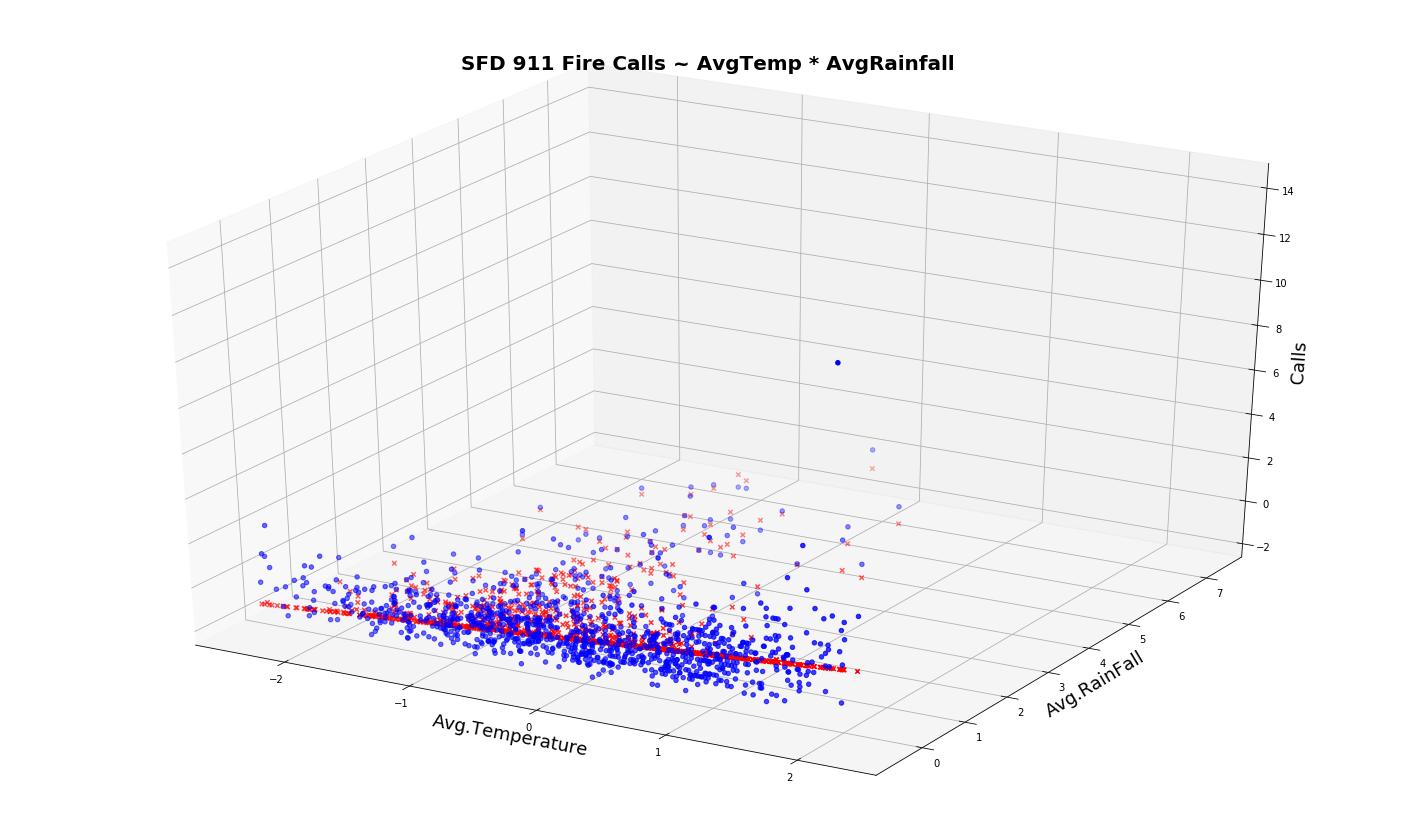

In [33]:
# Fitting model Calls ~ AvgTemp * AvgRainfall, and printing results.
X = sm.add_constant(allRegF.iloc[:,4:6])
y = allRegF.Calls
reg = smf.ols(formula= 'Calls~AvgTemp*AvgRainFall',data=allRegF).fit()
print(reg.summary())

# Plotting data and the fitted model Calls ~ AvgTemp * AvgRainfall, in 3D space.
plt.rcParams['figure.figsize'] = [25,15]
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('SFD 911 Fire Calls ~ AvgTemp * AvgRainfall',fontsize=20,fontweight='bold')
ax.scatter(allRegF.AvgTemp,allRegF.AvgRainFall,allRegF.Calls,c='b',marker='o')
ax.scatter(allRegF.AvgTemp,allRegF.AvgRainFall,reg.fittedvalues,c='r',marker='x')
ax.set_xlabel('Avg.Temperature',fontsize=18)
ax.set_ylabel('Avg.RainFall',fontsize=18)
ax.set_zlabel('Calls',fontsize=18)
plt.show

#### Code:
This block of code plots the residuals from the Calls ~ AvgTemp * AvgRainfall linear regression model (including the interaction term). 

#### Analysis:
Plot of the residuals confirms that the relationship between fire-related call volume and average daily air temperature and rainfall measurements in Seattle, is not linear. Either other variables are at work here, or we need a more complex model, or both. 

<Figure size 1800x720 with 0 Axes>

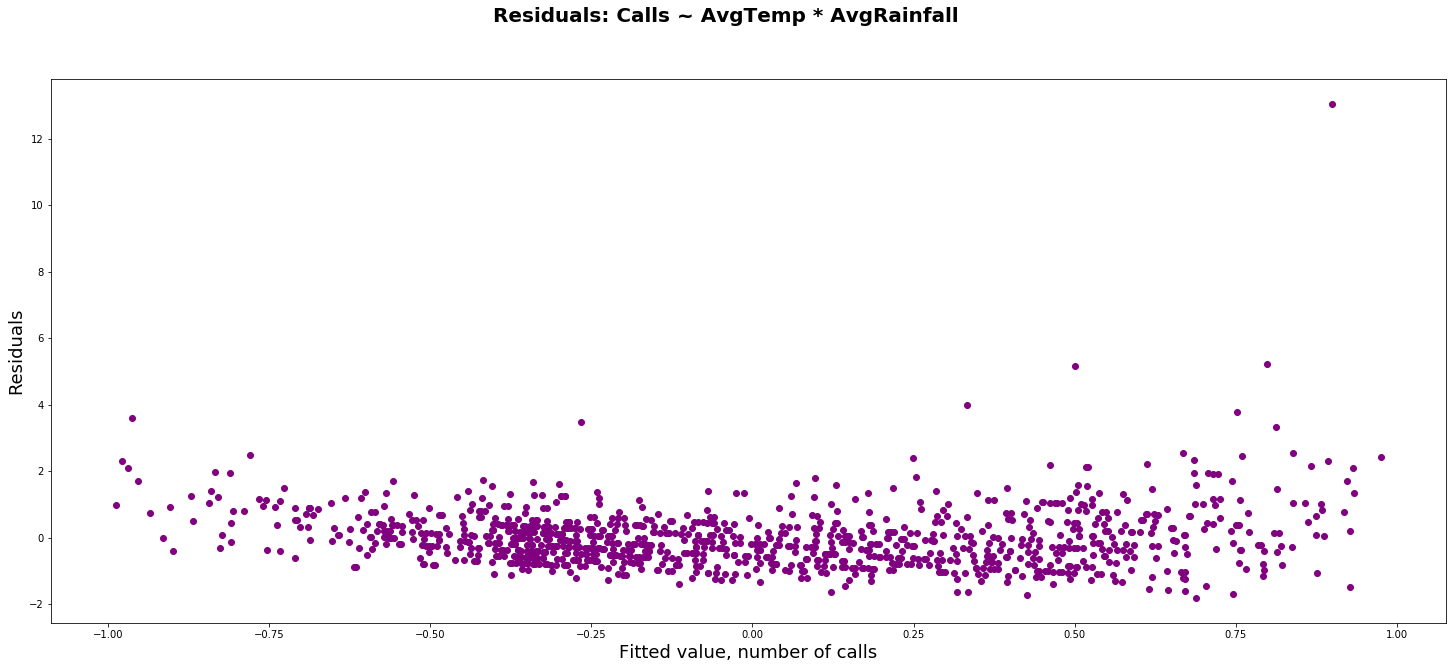

In [34]:
# Plotting residuals from the model Calls ~ AvgTemp * AvgRainfall
residual = reg.resid
fitted = reg.fittedvalues
plt.rcParams['figure.figsize'] = [25,10]
plt.clf()
fig = plt.figure()
fig.suptitle('Residuals: Calls ~ AvgTemp * AvgRainfall',fontsize=20,fontweight='bold')
plt.scatter(fitted,residual,color='purple');
plt.xlabel('Fitted value, number of calls',fontsize=18)
plt.ylabel('Residuals',fontsize=18)
plt.show()

#### Code:
In a final attempt to find a linear model that better describes the relationship between our variables, we fit a multivariate linear regression model using the square of the average daily rainfall and air temperature as independent variables, and fire-related calls as dependent variable. This model includes an interaction term between the two independent variables, and uses the ols (Ordinary Least Squares) package (Again, note that this is different from the OLS package used above).

#### Analysis:
Results show a lower performing model than the one where average daily air temperature is not raised to the square. Results are included for completness only.

In [35]:
# Fitting model Calls ~ (AvgTemp)^2 * AvgRainfall, and printing results.
X = sm.add_constant(allRegF.iloc[:,4:6])
y = allRegF.Calls
reg = smf.ols(formula= 'Calls~np.square(AvgTemp)*AvgRainFall',data=allRegF).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     61.29
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           1.26e-36
Time:                        15:13:02   Log-Likelihood:                -1469.4
No. Observations:                1096   AIC:                             2947.
Df Residuals:                    1092   BIC:                             2967.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Linear Regression analysis, non-fire related 911 calls
For non-fire related calls we fitted the same range of models as we did for fire-related calls. The results were very negative. That is, linear regression models using air temperature and rainfall as independent variables to explain non-fire relate call volumes in Seattle are not useful. The best model, shown below, been able to explain less thatn 1% of the variability in call volume values. 

#### Code:

The next block of code normalizes all three variables in our dataframe, by subtracting the mean of each variable from the corresponding data, and dividing by its standard deviation.

In [36]:
# Normalizing all three variables before fitting Linear Regression models, non-fire related calls.
allRegO['Calls'] = (allRegO['Calls'] - allRegO['Calls'].mean())/allRegO['Calls'].std()
allRegO['AvgTemp'] = (allRegO['AvgTemp'] - allRegO['AvgTemp'].mean())/allRegO['AvgTemp'].std()
allRegO['AvgRainFall'] = (allRegO['AvgRainFall'] - allRegO['AvgRainFall'].mean())/allRegO['AvgRainFall'].std()

#### Code:
We fit a multivariate simple linear regression model with average daily rainfall and air temperature as independent variables, and non-fire related calls as dependent variable, using the OLS (Ordinary Least Squares) package.

#### Analysis:
Results show a low R^2 value of 0.067. It's clear that though both correlation coefficients have p-values that indicate they are significant, the value of this linear model to explain non-fire related 911 call volumes in Seattle is practically null.

In [37]:
# Fitting model Calls ~ AvgTemp * AvgRainfall, and printing results.
X = sm.add_constant(allRegO.iloc[:,4:6])
y = allRegO.Calls
reg = smf.ols(formula= 'Calls~AvgTemp+AvgRainFall',data=allRegO).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Calls   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     39.22
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           3.55e-17
Time:                        15:13:02   Log-Likelihood:                -1518.1
No. Observations:                1097   AIC:                             3042.
Df Residuals:                    1094   BIC:                             3057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.554e-15      0.029  -8.75e-14      